In [1]:
# Code generated by Gemini 3
# Reviewed and modified by André Lindgren

import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.get_default_dtype()


def get_moons_dataset(n_samples=1000, noise=0.1, test_size=0.2, random_state=42):
    """
    Loads Moons dataset (2 features, 2 classes) and formats it into
    the dictionary structure required by KAN/MLP.
    """
    X, y = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dataset = {}

    dataset['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s=20)
    plt.title("Moons Dataset Visualization (2 Inputs, 2 Classes)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show() #

    return dataset


def plot_KAN_graph(kan_model):
    kan_model.plot(scale=1.0, beta=3)
    n = 2
    names = ["x0", "x1"]
    for i in range(n):
        plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")


def plot_decision_boundary(dataset, model, model_name):
    plt.figure(figsize=(8, 6))
    x_min, x_max = dataset['test_input'][:, 0].min() - 0.1, dataset['test_input'][:, 0].max() + 0.1
    y_min, y_max = dataset['test_input'][:, 1].min() - 0.1, dataset['test_input'][:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), 0.01), np.arange(y_min.item(), y_max.item(), 0.01))
    Z = torch.argmax(model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(dtype).to(device)), dim=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().detach().numpy(), alpha=0.4, cmap=plt.cm.Spectral)
    plt.scatter(dataset['test_input'][:, 0].cpu().numpy(), dataset['test_input'][:, 1].cpu().numpy(),
                c=dataset['test_label'].cpu().numpy(), s=20, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title(f"{model_name}, Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

In [2]:
def get_class_specific_datasets(full_dataset):
    """
    Splits the full dataset into two separate datasets, one for each class (0 and 1).
    """
    train_class_0_mask = full_dataset['train_label'] == 0
    train_class_1_mask = full_dataset['train_label'] == 1
    test_class_0_mask = full_dataset['test_label'] == 0
    test_class_1_mask = full_dataset['test_label'] == 1

    datasets = []

    # Dataset for Class 0
    datasets.append({
        'name': 'Class 0',
        'train_input': full_dataset['train_input'][train_class_0_mask],
        'train_label': full_dataset['train_label'][train_class_0_mask],
        'test_input': full_dataset['test_input'][test_class_0_mask],
        'test_label': full_dataset['test_label'][test_class_0_mask]
    })

    # Dataset for Class 1
    datasets.append({
        'name': 'Class 1',
        'train_input': full_dataset['train_input'][train_class_1_mask],
        'train_label': full_dataset['train_label'][train_class_1_mask],
        'test_input': full_dataset['test_input'][test_class_1_mask],
        'test_label': full_dataset['test_label'][test_class_1_mask]
    })

    # Create an 'All' dataset for post-training comparison
    all_dataset = {
        'name': 'All Classes',
        'train_input': full_dataset['train_input'],
        'train_label': full_dataset['train_label'],
        'test_input': full_dataset['test_input'],
        'test_label': full_dataset['test_label']
    }

    return datasets, all_dataset


def train_mlp_sequential(datasets_list, all_dataset, width, steps_per_class=20, seed=42):
    print(f"## Sequential MLP Training (Width: {width})")

    model = MLP(width=width, seed=seed, device=device)
    all_test_accuracies = []

    for i, dataset in enumerate(datasets_list):
        print(f"\n--- Training on {dataset['name']} (Stage {i+1}) ---")

        def train_acc():
            pred = torch.argmax(model(dataset['train_input']), dim=1)
            return torch.mean((pred == dataset['train_label']).type(dtype))

        def test_acc():
            pred = torch.argmax(model(dataset['test_input']), dim=1)
            return torch.mean((pred == dataset['test_label']).type(dtype))

        def all_test_acc():
            pred = torch.argmax(model(all_dataset['test_input']), dim=1)
            return torch.mean((pred == all_dataset['test_label']).type(dtype))

        initial_all_acc = all_test_acc().item()

        results = model.fit(dataset, opt="LBFGS", steps=steps_per_class, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

        final_all_acc = all_test_acc().item()
        print(f"Initial ALL Test Acc: {initial_all_acc:.4f}")
        print(f"Final ALL Test Acc: {final_all_acc:.4f}")

        all_test_accuracies.append({
            'stage': i+1,
            'class_trained': dataset['name'],
            'initial_all_acc': initial_all_acc,
            'final_all_acc': final_all_acc
        })

        plot_decision_boundary(all_dataset, model, f"MLP Trained on {dataset['name']}")

    return model, all_test_accuracies


def train_kan_sequential(datasets_list, all_dataset, width, grid=5, k=3, steps_per_class=20, seed=42):
    print(f"## Sequential KAN Training (Width: {width}, Grid: {grid})")

    model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero' )
    all_test_accuracies = []

    for i, dataset in enumerate(datasets_list):
        print(f"\n--- Training on {dataset['name']} (Stage {i+1}) ---")

        def train_acc():
            pred = torch.argmax(model(dataset['train_input']), dim=1)
            return torch.mean((pred == dataset['train_label']).type(dtype))

        def test_acc():
            pred = torch.argmax(model(dataset['test_input']), dim=1)
            return torch.mean((pred == dataset['test_label']).type(dtype))

        def all_test_acc():
            pred = torch.argmax(model(all_dataset['test_input']), dim=1)
            return torch.mean((pred == all_dataset['test_label']).type(dtype))

        initial_all_acc = all_test_acc().item()

        results = model.fit(dataset, opt="LBFGS", steps=steps_per_class, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), update_grid=False)

        final_all_acc = all_test_acc().item()
        print(f"Initial ALL Test Acc: {initial_all_acc:.4f}")
        print(f"Final ALL Test Acc: {final_all_acc:.4f}")

        all_test_accuracies.append({
            'stage': i+1,
            'class_trained': dataset['name'],
            'initial_all_acc': initial_all_acc,
            'final_all_acc': final_all_acc
        })

        plot_decision_boundary(all_dataset, model, f"KAN Trained on {dataset['name']}")

    return model, all_test_accuracies



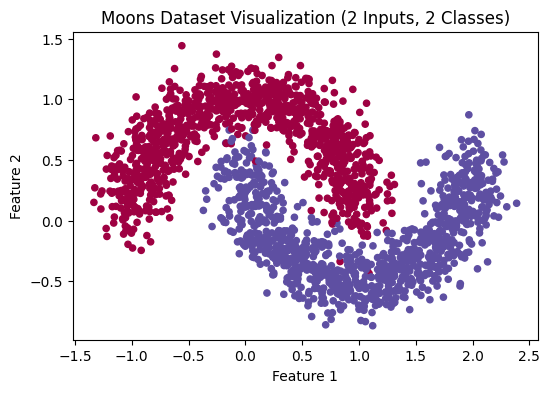

## 🧠 Sequential MLP Training (Width: [2, 3, 2])

--- Training on Class 0 (Stage 1) ---


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 1.80e+01 | : 100%|█| 25/25 [00:00<00:00, 38.78it


Initial ALL Test Acc: 0.5075
Final ALL Test Acc: 0.4925


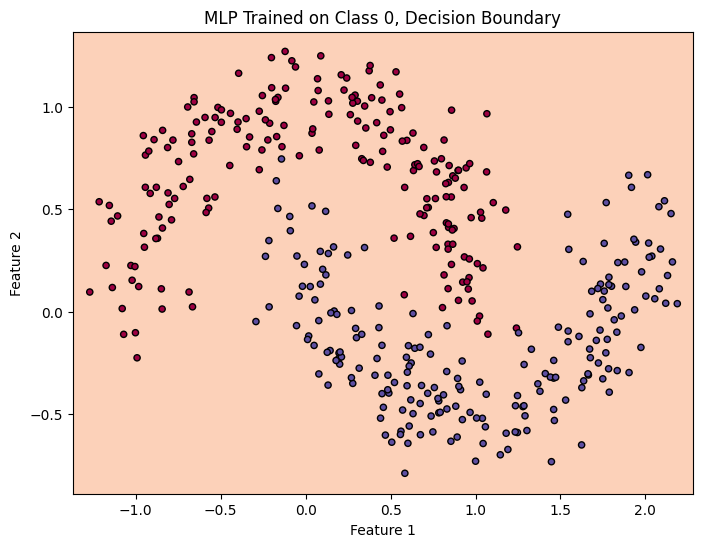


--- Training on Class 1 (Stage 2) ---


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 2.04e+01 | : 100%|█| 25/25 [00:00<00:00, 62.50it


Initial ALL Test Acc: 0.4925
Final ALL Test Acc: 0.5075


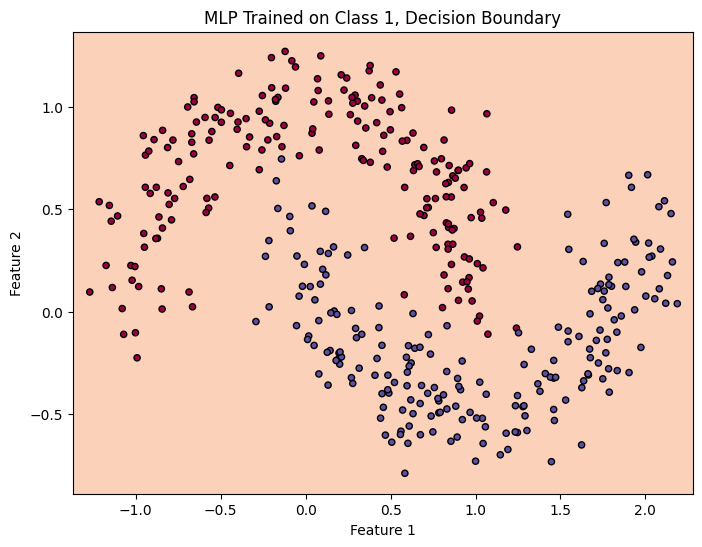

## Sequential KAN Training (Width: [2, 2], Grid: 50)
checkpoint directory created: ./model
saving model version 0.0

--- Training on Class 0 (Stage 1) ---


| train_loss: 0.00e+00 | test_loss: 2.33e-04 | reg: 2.36e+01 | : 100%|█| 25/25 [00:01<00:00, 19.31it


saving model version 0.1
Initial ALL Test Acc: 0.4700
Final ALL Test Acc: 0.4925


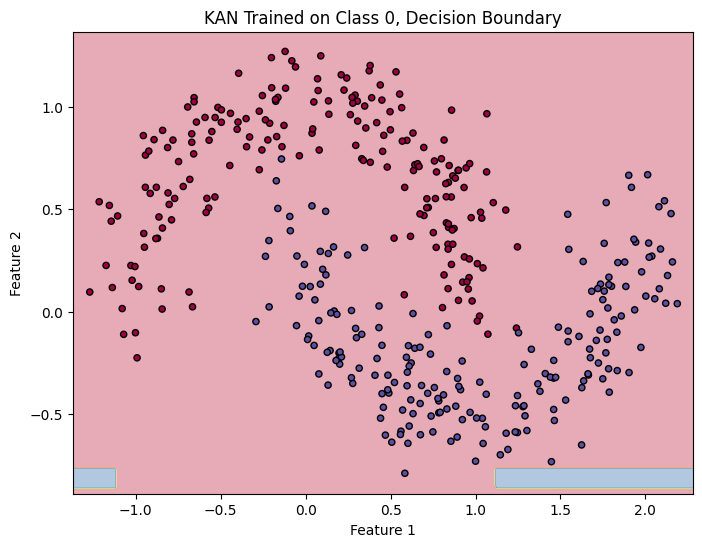


--- Training on Class 1 (Stage 2) ---


| train_loss: 0.00e+00 | test_loss: 6.41e-05 | reg: 5.93e+01 | : 100%|█| 25/25 [00:01<00:00, 19.33it


saving model version 0.2
Initial ALL Test Acc: 0.4925
Final ALL Test Acc: 0.5950


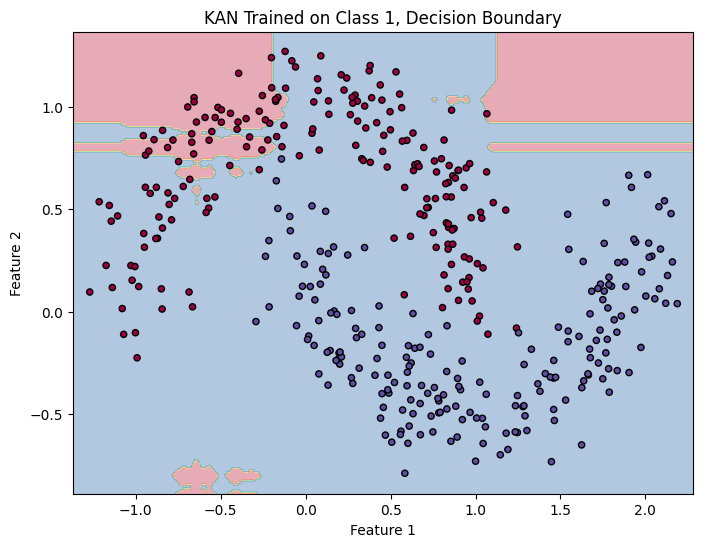

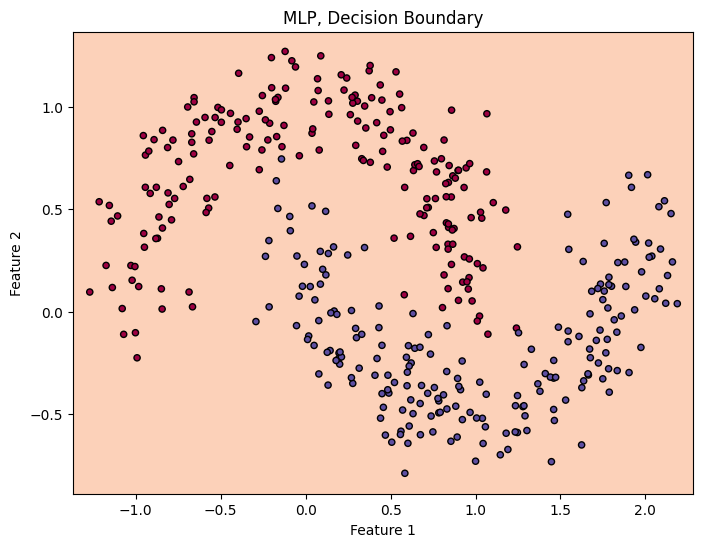

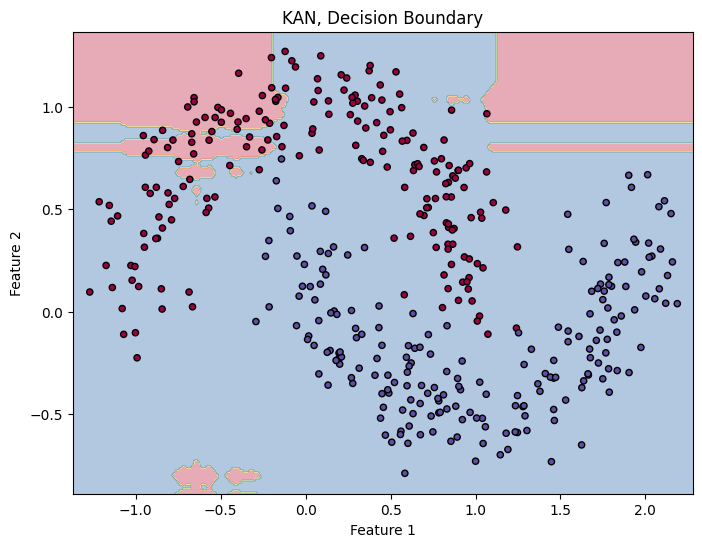

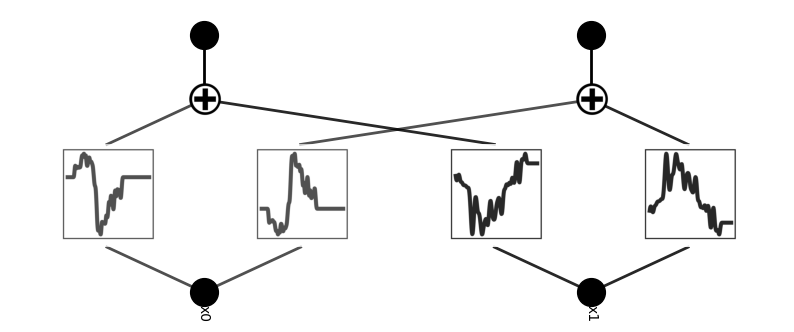

In [3]:
# ==========================================
#               MAIN EXECUTION
# ==========================================

dataset = get_moons_dataset(n_samples=2000, noise=0.15) # Increased samples/noise for a more complex test
class_datasets, all_data = get_class_specific_datasets(dataset)

sequential_steps = 25

mlp_seq_model, mlp_seq_accs = train_mlp_sequential(class_datasets, all_data, width=[2, 3, 2], steps_per_class=25, seed=42)
kan_seq_model, kan_seq_accs = train_kan_sequential(class_datasets, all_data, width=[2, 2], grid=50, k=3, steps_per_class=25, seed=42)

plot_decision_boundary(dataset, mlp_seq_model, "MLP")
plot_decision_boundary(dataset, kan_seq_model, "KAN")
plot_KAN_graph(kan_seq_model)
